# Viral Data Analysis

Date: 2021.10.11

Author: © 2021 Anonymous course participant

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/) [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from https://ourworldindata.org/ to answer the following questions:

1. [When did the OECD countries that spend most on healthcare per capita in 2019 had vaccinated (with one dose) at least 70% of the population?](#Q1)
1. [Does lower corruption in country correlates to percent of people vaccinated? (Europe)](#Q2)
1. [Can we predict when certain percent of population is vaccinated in France?](#Q3)

Additional data:
1. OECD https://stats.oecd.org/Index.aspx?ThemeTreeId=9#
2. CPI https://www.transparency.org/en/cpi/2020/table/nzl

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Preparations

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg

Download the data to cache locally. Do this once (a day), and comment out again, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [2]:
# import requests
# fname = 'owid-covid-data.csv'
# url = 'https://covid.ourworldindata.org/data/' + fname
# r = requests.get(url)
# open(fname, 'wb').write(r.content)

33717058

Load the file to Pandas.

In [3]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

Check the columns available.

In [4]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

### Prepare OECD data
Load and prepare OECD (Organisation for Economic Co-operation and Development) data from https://stats.oecd.org/Index.aspx?ThemeTreeId=9#

In [5]:
path = "oecd.csv" 
oecd_df = pd.read_csv(path)
oecd_df.columns

Index(['HF', 'Financing scheme', 'HC', 'Function', 'HP', 'Provider', 'MEASURE',
       'Measure', 'LOCATION', 'Country', 'TIME', 'Year', 'Unit Code', 'Unit',
       'PowerCode Code', 'PowerCode', 'Reference Period Code',
       'Reference Period', 'Value', 'Flag Codes', 'Flags'],
      dtype='object')

Filter out irrelevent data and data that has some flags on it (those indicate that data is prediction, not clear and etc.)

In [6]:
year = (oecd_df['TIME'] == 2019)
provider = (oecd_df['Provider'] == 'All providers')
scheme = (oecd_df['Financing scheme'] == 'All financing schemes')
function = (oecd_df['Function'] == 'Current expenditure on health (all functions)')
provider = (oecd_df['Provider'] == 'All providers')
measure = (oecd_df['Measure'] == 'Per capita, current prices, current PPPs')
flags = (oecd_df['Flag Codes'].isnull())
select_columns = ["Year", "LOCATION", "Country", "Unit Code", "Unit", "Value"]

oecd_df_filtered = oecd_df.loc[year & provider & scheme & function & provider & measure & flags][select_columns]
oecd_df_filtered.head(10)

,Year,LOCATION,Country,Unit Code,Unit,Value
53,2019,AUT,Austria,USD,US Dollar,5705.102
84,2019,BEL,Belgium,USD,US Dollar,5458.401
12017,2019,TUR,Turkey,USD,US Dollar,1266.935
12562,2019,USA,United States,USD,US Dollar,10948.475
15832,2019,ISL,Iceland,USD,US Dollar,4540.762
23786,2019,CHL,Chile,USD,US Dollar,2291.464
31999,2019,CHE,Switzerland,USD,US Dollar,7138.064
36621,2019,DEU,Germany,USD,US Dollar,6518.004
51183,2019,CZE,Czech Republic,USD,US Dollar,3417.487
54339,2019,DNK,Denmark,USD,US Dollar,5477.567


### Prepare CPI data
Load and prepare CPI (Corruption Perceptions Index) data from https://www.transparency.org/en/cpi/2020/table/nzl

In [7]:
path = "cpi2020.xlsx" 
cpi_df = pd.read_excel(path)
cpi_df.columns

Index(['Country', 'ISO3', 'Region', 'CPI score 2020', 'Rank', 'Standard error',
       'Number of sources', 'Lower CI', 'Upper CI',
       'African Development Bank CPIA',
       'Bertelsmann Foundation Sustainable Governance Index',
       'Bertelsmann Foundation Transformation Index',
       'Economist Intelligence Unit Country Ratings',
       'Freedom House Nations in Transit',
       'Global Insight Country Risk Ratings',
       'IMD World Competitiveness Yearbook', 'PERC Asia Risk Guide',
       'PRS International Country Risk Guide',
       'Varieties of Democracy Project', 'World Bank CPIA',
       'World Economic Forum EOS', 'World Justice Project Rule of Law Index'],
      dtype='object')

<a id='Q1'></a>
# 1. When did the OECD countries that spend most on healthcare per capita in 2019 had vaccinated (with one dose) at least 70% of the population?

Sort filtered OECD data by value. Value in this case is current expenditure on health per capita in USD.

In [8]:
oecd_df_sorted = oecd_df_filtered.sort_values('Value', ascending=False)
oecd_df_sorted.head(5)

,Year,LOCATION,Country,Unit Code,Unit,Value
12562,2019,USA,United States,USD,US Dollar,10948.475
31999,2019,CHE,Switzerland,USD,US Dollar,7138.064
116214,2019,NOR,Norway,USD,US Dollar,6744.623
36621,2019,DEU,Germany,USD,US Dollar,6518.004
111822,2019,NLD,Netherlands,USD,US Dollar,5739.201


Select 2021 vaccination data, since most of the countries began vaccination at the beginning of 2021

In [9]:
date_2021 = pd.Timestamp(2021, 1, 1)
df_2021 = df.drop(df[df.date < date_2021].index)

Select top 10 OECD countries that spend most on healthcare per capita and show their data on vaccination. For vaccination date use people_vaccinated_per_hundred that basically shows percent of population that received at least one dose (which usually indicates that they are also planning to gain second one)

Text(0.5, 1.0, 'COVID-19 people vaccinated per hundred')

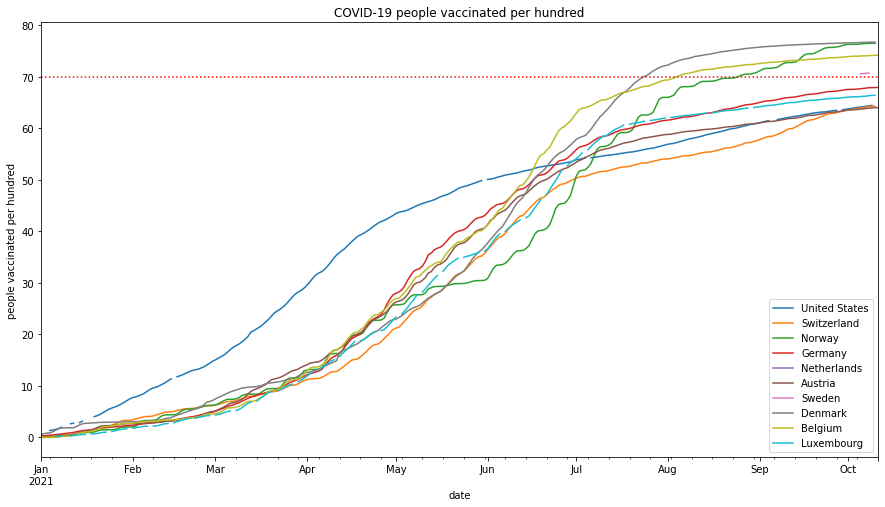

In [10]:
countries = oecd_df_sorted["LOCATION"].iloc[:10].values
country_names = []
selected_column = 'people_vaccinated_per_hundred'
name = selected_column.replace('_', ' ')
ax = None
for c in countries:
    ax = df_2021[df_2021.iso_code==c].plot( x='date', y=selected_column, figsize=(15,8), title=c, ax=ax)
    country_names.append( df_2021[df_2021["iso_code"] == c].iloc[0].location )

plt.axhline(y=70, color='r', linestyle='dotted')
plt.ylabel(name)
plt.legend(country_names)
plt.title('COVID-19 ' + name)

From a graph we can see, that not all of the selected countries reached desired 70% vaccination rate. So we can check which countries and when managed to reached 70%.

In [11]:
columns = ['location', 'date']
conditions = (df.iso_code.isin(countries)) & (df['people_vaccinated_per_hundred'] >= 70)

result = df[conditions][columns].groupby(df.iso_code).min()

def find_people_vaccinated_per_hundred (row):
    return (df[(df.iso_code == row.name) & (df.date == row['date'])]['people_vaccinated_per_hundred'].values[0])

result['people_vaccinated_per_hundred'] = result.apply(lambda row: find_people_vaccinated_per_hundred(row), axis=1)
result.sort_values('date', ascending=True)

,location,date,people_vaccinated_per_hundred
iso_code,,,
DNK,Denmark,2021-07-24,70.10
NLD,Netherlands,2021-07-25,70.55
BEL,Belgium,2021-08-04,70.05
NOR,Norway,2021-08-25,70.11
SWE,Sweden,2021-09-26,70.19


<a id='Q2'></a>
# 2. Does lower corruption in country correlates to percent of people vaccinated? (Europe)
Lower corruption tend to indicate effective government and higher trust of government by population

Select latest vaccination data for European countries

In [12]:
continent = (df['continent'] == 'Europe')
columns = ['location', 'people_vaccinated_per_hundred']

europe_latest_df = df[continent].groupby('iso_code').last()[columns]
europe_latest_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, ALB to VAT
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   location                       51 non-null     object 
 1   people_vaccinated_per_hundred  50 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


Adjust CPI data and merge to latest vaccination data on iso_code

In [13]:
cpi_df = cpi_df.rename(columns={"ISO3": "iso_code"})

europe_df = pd.merge(europe_latest_df, cpi_df, on='iso_code')
europe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 24 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   iso_code                                             40 non-null     object 
 1   location                                             40 non-null     object 
 2   people_vaccinated_per_hundred                        40 non-null     float64
 3   Country                                              40 non-null     object 
 4   Region                                               40 non-null     object 
 5   CPI score 2020                                       40 non-null     int64  
 6   Rank                                                 40 non-null     int64  
 7   Standard error                                       40 non-null     float64
 8   Number of sources                                    40 non-null     int

Plot the merged data

Text(0.5, 1.0, 'CPI score 2020 / people vaccinated per hundred')

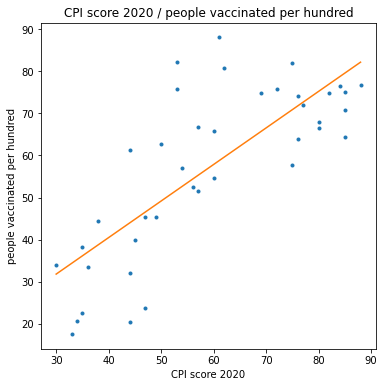

In [14]:
plt.figure(figsize=(6,6))
x = europe_df['CPI score 2020']
y = europe_df['people_vaccinated_per_hundred']
plt.plot(x, y, '.')
plt.xlabel('CPI score 2020')
plt.ylabel('people vaccinated per hundred')

z = ma.polyfit(ma.masked_invalid(x), ma.masked_invalid(y), 1)
p = np.poly1d(z)
x_all = np.linspace(x.min(), x.max(), 100)
plt.plot(x_all, p(x_all), '-')
plt.title('CPI score 2020 / people vaccinated per hundred')

We can see that there is some positive correlation between CPI and people vaccinated per hundred

In [15]:
ma.corrcoef(ma.masked_invalid(x), ma.masked_invalid(y))[0,1]

0.7659505227339756

As we can see there is a correlation between CPI and people vaccinated per hundred. A couple of explanations for outliers:

    1.Countries with low CPI is not in EU and therefore had more difficulty accessing (quality) vaccines
    2.Some countries with average CPI might had strong other motivations to vaccinate (e.g. huge first wave)

In [16]:
condition = (europe_df['CPI score 2020'] < 50) & (europe_df['Region'] != 'WE/EU')
europe_df[condition][['location', 'Region', 'CPI score 2020', 'people_vaccinated_per_hundred']]

,location,Region,CPI score 2020,people_vaccinated_per_hundred
0,Albania,ECA,36,33.49
4,Bosnia and Herzegovina,ECA,35,22.50
5,Belarus,ECA,47,23.67
25,Moldova,ECA,34,20.50
26,North Macedonia,ECA,35,38.22
28,Montenegro,ECA,45,39.96
34,Russia,ECA,30,33.97
35,Serbia,ECA,38,44.31
39,Ukraine,ECA,33,17.51


Here we can notice that countries with low CPI score and low vaccination rate are also not EU countries. This could indicate that one of the reasons for lower vaccination rate is that those counties had more difficult access to the vaccines, in particular quality ones.

In [17]:
condition = (europe_df['CPI score 2020'] > 50) & (europe_df['CPI score 2020'] < 70) & (europe_df['people_vaccinated_per_hundred'] > 70)
europe_df[condition][['location', 'CPI score 2020', 'people_vaccinated_per_hundred']]

,location,CPI score 2020,people_vaccinated_per_hundred
11,Spain,62,80.90
14,France,69,74.96
21,Italy,53,75.91
27,Malta,53,82.37
32,Portugal,61,88.10


Here we can see that a couple of countries indeed had a notorious first wave (particularly Italy and Spain) and that might have caused additional increase in vaccination rates.

<a id='Q3'></a>
## 3. Can we predict when certain percent of population is vaccinated in France?

To predict when certain percent of population is vaccinated, we will use time series analysis. The goal is to forecast percent of population vaccinated from historical data. If we could do that, then we can answer our question.

### Prepare training and testing data

Select relevant data

In [18]:
condition = (df.iso_code == 'FRA') & (df.people_vaccinated_per_hundred > 0)
FRA_df = df[condition]
FRA_df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
40091,FRA,Europe,France,2021-01-04,2717059.0,4084.0,13915.571,65548.0,385.0,330.571,...,30.1,35.6,NaN,5.98,82.66,0.901,NaN,NaN,NaN,NaN
40092,FRA,Europe,France,2021-01-05,2737892.0,20833.0,15249.714,66416.0,868.0,316.143,...,30.1,35.6,NaN,5.98,82.66,0.901,NaN,NaN,NaN,NaN
40093,FRA,Europe,France,2021-01-06,2763078.0,25186.0,15060.000,66698.0,282.0,313.000,...,30.1,35.6,NaN,5.98,82.66,0.901,NaN,NaN,NaN,NaN
40094,FRA,Europe,France,2021-01-07,2784845.0,21767.0,15312.143,66974.0,276.0,316.571,...,30.1,35.6,NaN,5.98,82.66,0.901,NaN,NaN,NaN,NaN
40095,FRA,Europe,France,2021-01-08,2804705.0,19860.0,15383.857,67565.0,591.0,382.000,...,30.1,35.6,NaN,5.98,82.66,0.901,NaN,NaN,NaN,NaN


Prepare data by selecting columns, sorting, removing NaN values and reindexing.

In [19]:
FRA_df_simple = FRA_df[['date', 'people_vaccinated_per_hundred']].dropna().sort_values('date', ascending=True).reset_index()
FRA_df_simple.head()

,index,date,people_vaccinated_per_hundred
0,40091,2021-01-04,0.01
1,40092,2021-01-05,0.01
2,40093,2021-01-06,0.03
3,40094,2021-01-07,0.08
4,40095,2021-01-08,0.13


To use historical data we add columns h1 - h10 using sliding window method.

In [20]:
def getHistoricalData (row, d):
    if row.name >= d:
        return FRA_df_simple.iloc[(row.name - d), 2]
    return 0

FRA_df_simple['h1'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 1), axis=1)
FRA_df_simple['h2'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 2), axis=1)
FRA_df_simple['h3'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 3), axis=1)
FRA_df_simple['h4'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 4), axis=1)
FRA_df_simple['h5'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 5), axis=1)
FRA_df_simple['h6'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 6), axis=1)
FRA_df_simple['h7'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 7), axis=1)
FRA_df_simple['h8'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 8), axis=1)
FRA_df_simple['h9'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 9), axis=1)
FRA_df_simple['h10'] = FRA_df_simple.apply(lambda x: getHistoricalData(x, 10), axis=1)
FRA_df_simple.head(8)

,index,date,people_vaccinated_per_hundred,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10
0,40091,2021-01-04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
1,40092,2021-01-05,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
2,40093,2021-01-06,0.03,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
3,40094,2021-01-07,0.08,0.03,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0.0,0.0
4,40095,2021-01-08,0.13,0.08,0.03,0.01,0.01,0.00,0.00,0.00,0.0,0.0,0.0
5,40096,2021-01-09,0.15,0.13,0.08,0.03,0.01,0.01,0.00,0.00,0.0,0.0,0.0
6,40097,2021-01-10,0.15,0.15,0.13,0.08,0.03,0.01,0.01,0.00,0.0,0.0,0.0
7,40098,2021-01-11,0.21,0.15,0.15,0.13,0.08,0.03,0.01,0.01,0.0,0.0,0.0


To simplify date to something we can include in calculations we calculate delta from some point in time.

In [21]:
time_point = mdates.date2num(pd.to_datetime('20210101', format='%Y%m%d', errors='ignore'))

FRA_df_simple['delta'] = mdates.date2num(FRA_df_simple['date'])
FRA_df_simple['delta'] = FRA_df_simple.apply(lambda row: row['delta'] - time_point, axis=1)

Then we will split data into training and testing sets by date

In [22]:
date_to_split = pd.Timestamp(2021, 9, 1)
FRA_df_simple_train = FRA_df_simple[FRA_df_simple.date < date_to_split]
FRA_df_simple_test = FRA_df_simple[FRA_df_simple.date >= date_to_split]
FRA_df_simple_test.head()

,index,date,people_vaccinated_per_hundred,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,delta
240,40331,2021-09-01,72.21,72.03,71.84,71.67,71.63,71.50,71.28,71.07,70.85,70.61,70.41,243.0
241,40332,2021-09-02,72.36,72.21,72.03,71.84,71.67,71.63,71.50,71.28,71.07,70.85,70.61,244.0
242,40333,2021-09-03,72.53,72.36,72.21,72.03,71.84,71.67,71.63,71.50,71.28,71.07,70.85,245.0
243,40334,2021-09-04,72.66,72.53,72.36,72.21,72.03,71.84,71.67,71.63,71.50,71.28,71.07,246.0
244,40335,2021-09-05,72.69,72.66,72.53,72.36,72.21,72.03,71.84,71.67,71.63,71.50,71.28,247.0


Before we prepare our model, first we will try a few basic approaches to have some baseline. First one is polynomial fit. 4th degree polynomial had lowest RMSE and 3rd degree polynomial matches the training data curve.

In [23]:
z4 = np.polyfit(FRA_df_simple_train['delta'], FRA_df_simple_train['people_vaccinated_per_hundred'], 4)
p4 = np.poly1d(z4)

p4_actual_data = FRA_df_simple_test['people_vaccinated_per_hundred'].values
p4_fit = p4(FRA_df_simple_train['delta'])
p4_pred = p4(FRA_df_simple_test['delta'])

p4_residuals = p4_pred - p4_actual_data
p4_rmse = np.sqrt(np.sum(np.power(p4_residuals,2)) / len(p4_residuals))
print('RMSE = %.2f' % p4_rmse)

z3 = np.polyfit(FRA_df_simple_train['delta'], FRA_df_simple_train['people_vaccinated_per_hundred'], 3)
p3 = np.poly1d(z3)

p3_actual_data = FRA_df_simple_test['people_vaccinated_per_hundred'].values
p3_fit = p3(FRA_df_simple_train['delta'])
p3_pred = p3(FRA_df_simple_test['delta'])

p3_residuals = p3_pred - p3_actual_data
p3_rmse = np.sqrt(np.sum(np.power(p3_residuals,2)) / len(p3_residuals))
print('RMSE = %.2f' % p3_rmse)

RMSE = 0.51
RMSE = 2.97


Plot these curves

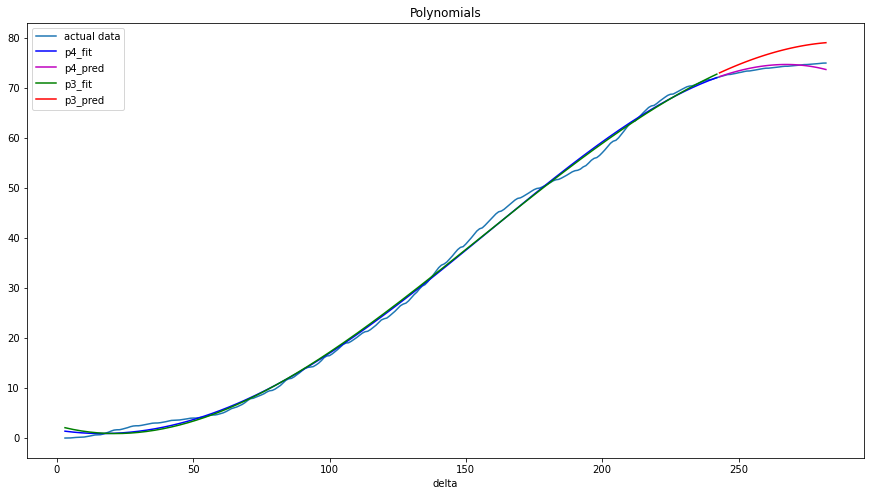

In [38]:
ax = None
ax = FRA_df_simple.plot( x='delta', y='people_vaccinated_per_hundred', figsize=(15,8), title='FRA', ax=ax)

ax.plot(FRA_df_simple_train['delta'], p4_fit, '-b')
ax.plot(FRA_df_simple_test['delta'], p4_pred, '-m')

ax.plot(FRA_df_simple_train['delta'], p3_fit, '-g')
ax.plot(FRA_df_simple_test['delta'], p3_pred, '-r')

plt.title('Polynomials')
plt.legend(['actual data', 'p4_fit', 'p4_pred', 'p3_fit', 'p3_pred'])
plt.show()

Most simple time series model - we just return previous historical data

In [25]:
h_actual_data = FRA_df_simple_test['people_vaccinated_per_hundred'].values
h_fit = FRA_df_simple_train['h1']
h_pred = FRA_df_simple_test['h1']

h_residuals = h_pred - h_actual_data
h_rmse = np.sqrt(np.sum(np.power(h_residuals,2)) / len(h_residuals))
print('RMSE = %.2f' % h_rmse)

RMSE = 0.08


This simple model performs better than polynomial fit.
Then we prepare Linear Regression model, that takes in historical data as input. Selected parameters returned lowest RMSE.

In [26]:
columns = ['h1', 'h2', 'h3', 'h10']

fra_lr_model = LinearRegression()
fra_lr_model.fit(FRA_df_simple_train[columns], FRA_df_simple_train['people_vaccinated_per_hundred'])

lr_actual_data = FRA_df_simple_test['people_vaccinated_per_hundred'].values
lr_fit = fra_lr_model.predict(FRA_df_simple_train[columns])
lr_pred = fra_lr_model.predict(FRA_df_simple_test[columns])

lr_residuals = lr_pred - lr_actual_data
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)

RMSE = 0.03


This model performed better than our simple approach.

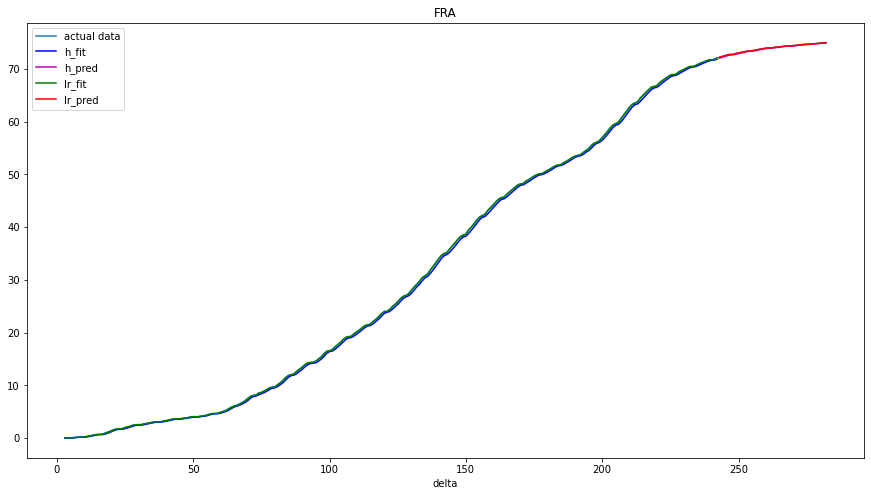

In [42]:
ax = None
ax = FRA_df_simple.plot( x='delta', y='people_vaccinated_per_hundred', figsize=(15,8), title='FRA', ax=ax)

ax.plot(FRA_df_simple_train['delta'], h_fit, '-b')
ax.plot(FRA_df_simple_test['delta'], h_pred, '-m')

ax.plot(FRA_df_simple_train['delta'], lr_fit, '-g')
ax.plot(FRA_df_simple_test['delta'], lr_pred, '-r')

plt.legend(['actual data', 'h_fit', 'h_pred', 'lr_fit', 'lr_pred'])
plt.show()

To see clearer plot testing results.

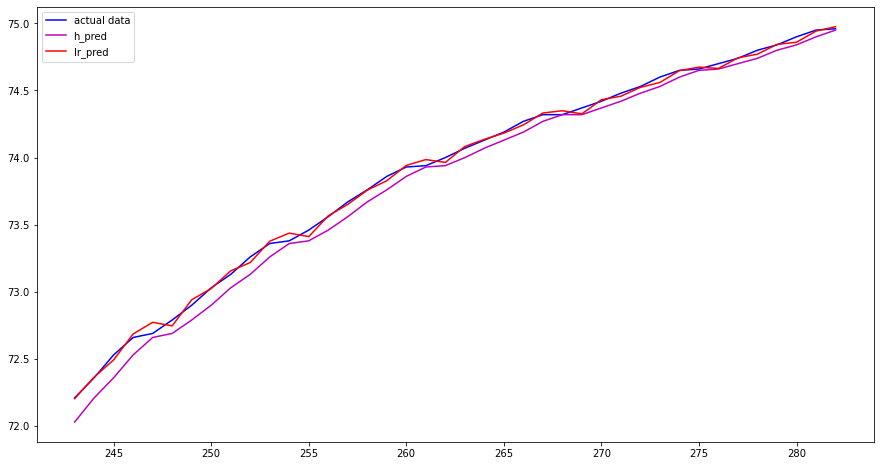

In [41]:
plt.figure(1, [15,8])
plt.plot(FRA_df_simple_test['delta'], FRA_df_simple_test['people_vaccinated_per_hundred'], '-b')

plt.plot(FRA_df_simple_test['delta'], h_pred, '-m')
plt.plot(FRA_df_simple_test['delta'], lr_pred, '-r')

plt.legend(['actual data', 'h_pred', 'lr_pred'])
plt.show()

From graph we can see that Linear Regression model works quite well, but cannot predict minor changes and takes some time to react to it. Also, these models are so accurate because we provide up to date input data, so basically, they rely on the newest data to forecast one day forward. We can test what happens if we provide its own predictions to forecast future data.

In [29]:
lr_pred_new = []

value = FRA_df_simple_train.iloc[-1, :]
q = [value['h9'], value['h8'], value['h7'], value['h6'], value['h5'], value['h4']]
v = [value['h1'], value['h2'], value['h3'], value['h10']]

for x in range(lr_actual_data.size):
    pred = fra_lr_model.predict([v])
    q.append(v[2])
    v[3] = q.pop()
    v[2] = v[1]
    v[1] = v[0]
    v[0] = pred[0]    
    lr_pred_new.append(pred[0])
    
lr_residuals_new = lr_pred_new - lr_actual_data
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals_new,2)) / len(lr_residuals_new))
print('RMSE = %.2f' % lr_rmse)

RMSE = 2.40


Performance quickly goes down if we do not provide newest data to adjust predictions

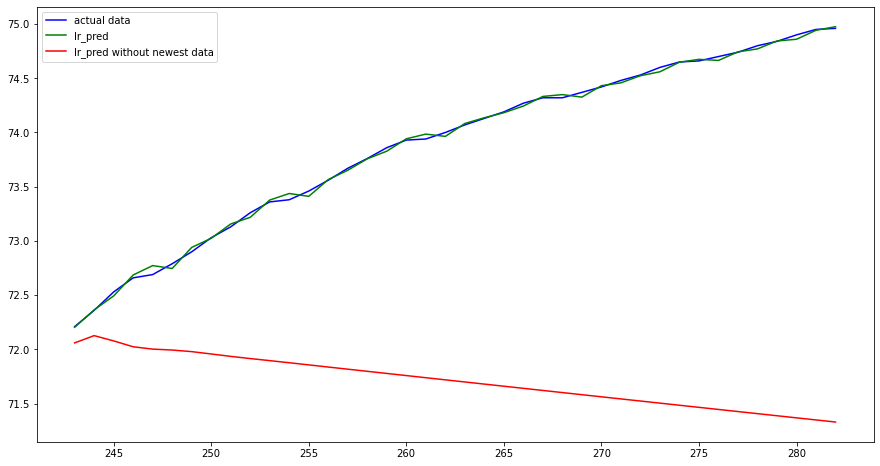

In [44]:
plt.figure(1, [15,8])
plt.plot(FRA_df_simple_test['delta'], FRA_df_simple_test['people_vaccinated_per_hundred'], '-b')

plt.plot(FRA_df_simple_test['delta'], lr_pred, '-g')
plt.plot(FRA_df_simple_test['delta'], lr_pred_new, '-r')

plt.legend(['actual data', 'lr_pred', 'lr_pred without newest data'])
plt.show()

Lastly, we use Autoregressive AR-X(p) model. After some tests it turned out that this configuration had smallest RMSE

In [31]:
fra_ar_model = AutoReg(FRA_df_simple_train['people_vaccinated_per_hundred'], lags=[1, 2, 3, 5, 6, 7, 9]).fit()

ar_actual_data = FRA_df_simple_test['people_vaccinated_per_hundred'].values
ar_pred = fra_ar_model.predict(start=FRA_df_simple_test['people_vaccinated_per_hundred'].index.min(), end=FRA_df_simple_test['people_vaccinated_per_hundred'].index.max())

ar_residuals = ar_pred - ar_actual_data
ar_rmse = np.sqrt(np.sum(np.power(ar_residuals,2)) / len(ar_residuals))
print('RMSE = %.2f' % ar_rmse)
ar_pred.head()

RMSE = 0.42


C:\Users\HP\Desktop\WPy64-3950\python-3.9.5.amd64\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


240    72.187362
241    72.354736
242    72.536155
243    72.617013
244    72.680053
dtype: float64

Plot results

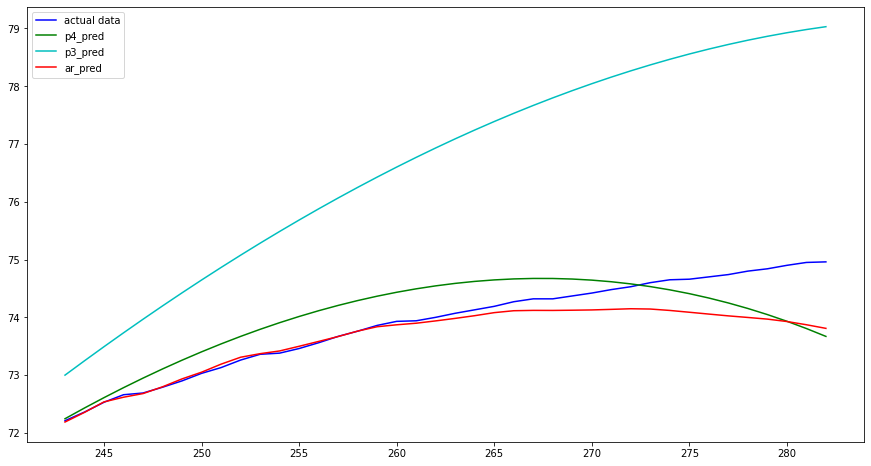

In [45]:
plt.figure(1, [15,8])
plt.plot(FRA_df_simple_test['delta'], FRA_df_simple_test['people_vaccinated_per_hundred'], '-b')

plt.plot(FRA_df_simple_test['delta'], p4_pred, '-g')
plt.plot(FRA_df_simple_test['delta'], p3_pred, '-c')
plt.plot(FRA_df_simple_test['delta'], ar_pred, '-r')

plt.legend(['actual data', 'p4_pred', 'p3_pred', 'ar_pred'])

plt.show()

So, to answer the question “Can we predict when certain percent of population is vaccinated in France?”, it depends. As we could see – mostly how far in the future is that event, because we managed to achieve quite good predictions in the near future, but the farther we look, the worse is prediction. These models didn’t include other data available. Also, they are quite basic and predicts exact result, so something that forecasts probability might work better in this case.